In [1]:
from gibbs import *
from data_pertub import *
from mcmc_plot import *
from geweke_full import *
from data_pertub import *

## 1. Data Perturbation

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [3]:
# data generation parameter
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epislon = float(data_config['epsilon'])
beta_vj = epislon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


true sigma2_star is 0.04916804519876983
true v_j list is [1.48971089]


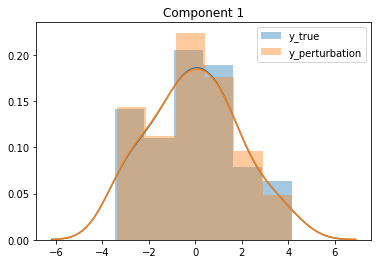

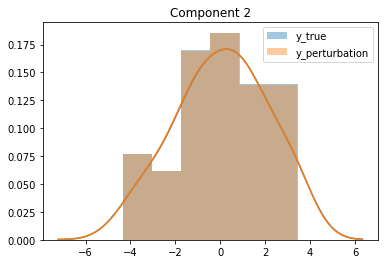

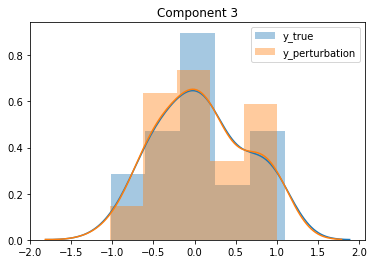

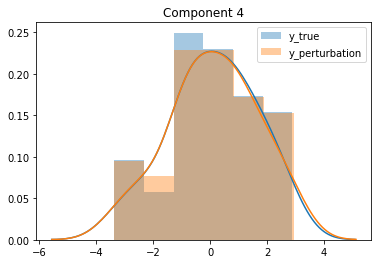

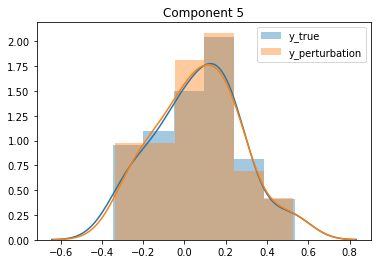

In [4]:
y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(
    d, q_star, n_sample, prior_param_true, verbose=True)

y_perturbation = sample_perturbation2(y_true, n_sample, alpha)
#y_perturbation = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)

for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_perturbation[j,:], label='y_perturbation')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()

In [5]:
X = y_perturbation

## 2. MCMC Prior

In [6]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [12]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
beta_vj = float(mcmc_setup['beta_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
#beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         #'a_vj': a_vj,
                         #'beta_vj': beta_vj
                         'a_vj': 0.5,
                         'beta_vj': 0.01
                         })

In [13]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

## 3. MCMC Standard

In [14]:
mcmc_list = []
for sub_chains in range(n_chains):
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, n_sample]),
                      "sigma20": sigma2_star,
                      # "w0": W_star,
                      'w0': np.random.normal(0, 1, [d, q]),
                      # 'v0': np.repeat(v_star_list, q).ravel(),
                       'v0': np.array(sorted(v_star_list))})
                      #'v0': sorted(1/np.random.gamma(a_vj, 1 / beta_vj))})

    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi=1)
    mcmc_list.append(inference.gibbs_result())

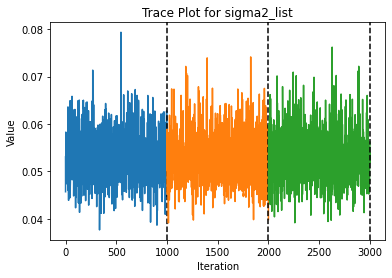

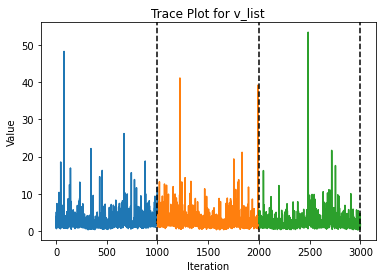

In [15]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [16]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

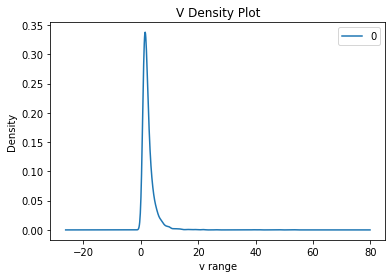

In [17]:
v_table = plot_v_density(v_list)

In [18]:
np.mean(v_list, axis=1)

array([[2.66314614],
       [2.84976666],
       [2.38549253]])

In [19]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/(prior_param_true['a_vj']-1)))

Inference v[2.63280177]
True v[2.]


## 4. MCMC Approx

In [20]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(prior_param_mcmc['a_sigma2'], 1/prior_param_mcmc['beta_sigma2']),                      
#                      "sigma20": np.random.gamma(3, 0.1),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   
                      
    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi = xi)                      
    mcmc_list.append(inference.gibbs_result())

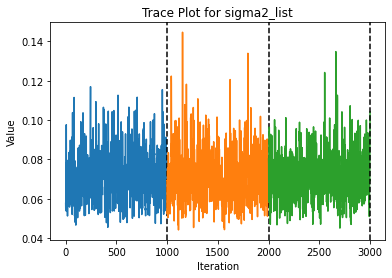

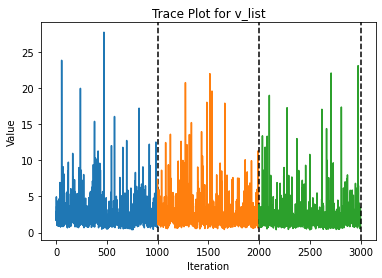

In [21]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [22]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

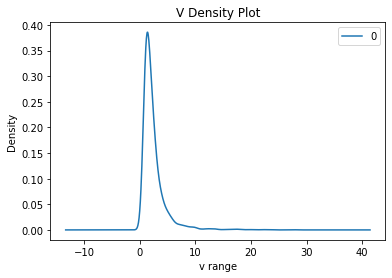

In [23]:
v_table = plot_v_density(v_list)

In [24]:
np.mean(v_list, axis=1)

array([[2.47564045],
       [2.61863921],
       [2.24455605]])

In [25]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/(prior_param_true['a_vj']-1)))

Inference v[2.44627857]
True v[2.]
